# Week 4: NLP Disaster Tweets Kaggle Mini-Project
## Fateme Hoshyar Zare

# 1. Brief Description of the Problem and Data
## 1-1. Introduction
Social media platforms like Twitter have become crucial channels for real-time communication during emergencies.
This project aims to build a machine learning model that can predict whether a tweet is related to a disaster or not.

# 1-2. Import Libraries
We'll start by importing the necessary Python libraries.


In [1]:

# Basic libraries
import os
import numpy as np
import pandas as pd

# Libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Libraries for text processing
import string
import re

# Library for natural language processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Library for splitting dataset
from sklearn.model_selection import train_test_split

# Libraries for neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

# Library for evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score

import warnings
warnings.filterwarnings("ignore")


# 1-3. Import Data
First, we will check the data files and import them. Next, we will take a look at the data.

In [3]:
# Provide the local paths to the datasets
train_data_path = r"C:\Users\farza\OneDrive\Fateme's projects\Fateme\nlp-getting-started\train.csv"
test_data_path = r"C:\Users\farza\OneDrive\Fateme's projects\Fateme\nlp-getting-started\test.csv"

# Load datasets
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Display samples from the training data
print(train_data.sample(5))

# The training data includes 'id,' 'keyword,' 'location,' 'text,' and 'target.'
# The target column indicates whether a tweet is related to a disaster (1) or not (0).

# Display samples from the test data
print(test_data.sample(5))

# Print the shape of the datasets
print("Train data: Number of rows =", train_data.shape[0], ", Number of columns =", train_data.shape[1])
print("Test data: Number of rows =", test_data.shape[0], ", Number of columns =", test_data.shape[1])


        id       keyword                        location  \
3334  4775     evacuated                  Manchester, UK   
6629  9493     terrorist  Iraq|Afghanistan| RSA |Baghdad   
6250  8931     snowstorm              Neath, South Wales   
5815  8298        rubble                             NaN   
6713  9613  thunderstorm                   United States   

                                                   text  target  
3334  Trafford Centre film fans angry after Odeon ci...       1  
6629        Natural lubrication !!!!!!!!!!!#MetroFmTalk       0  
6250  #NowPlaying Last Smoke Before The Snowstorm by...       0  
5815  My parents are so impulsive sometimes. I remem...       0  
6713  OUN cancels Severe Thunderstorm Warning for Li...       1  
         id       keyword     location  \
3174  10530      wildfire          NaN   
1908   6435       injured    bangalore   
3182  10556     windstorm          NaN   
1589   5370  fire%20truck     New York   
1784   6025     hazardous  New Ze

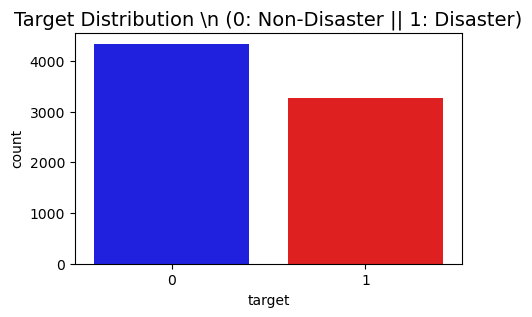

target
0    4342
1    3271
Name: count, dtype: int64


In [4]:

# 2. Exploratory Data Analysis (EDA)
# 2-1. Target Distribution
# We will examine the distribution of the 'target' in the training data.

plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x='target', data=train_data, palette=colors)
plt.title('Target Distribution \\n (0: Non-Disaster || 1: Disaster)', fontsize=14)
plt.show()

print(train_data['target'].value_counts())


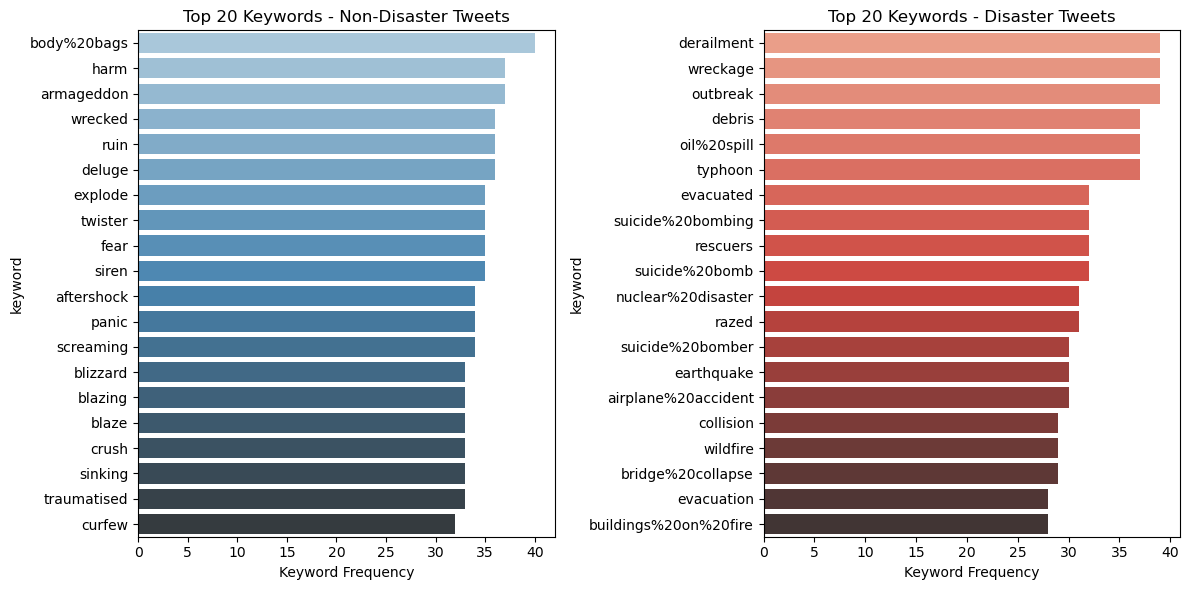

In [5]:

# 2-2. Top 20 Keywords
# We will identify the top 20 keywords for both 'Non-disaster' and 'Disaster' tweets.

nondisaster_keywords = train_data.loc[train_data["target"] == 0]["keyword"].value_counts()
disaster_keywords = train_data.loc[train_data["target"] == 1]["keyword"].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[0], palette="Blues_d")
ax[0].set_title("Top 20 Keywords - Non-Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[1], palette="Reds_d")
ax[1].set_title("Top 20 Keywords - Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")

plt.tight_layout()
plt.show()


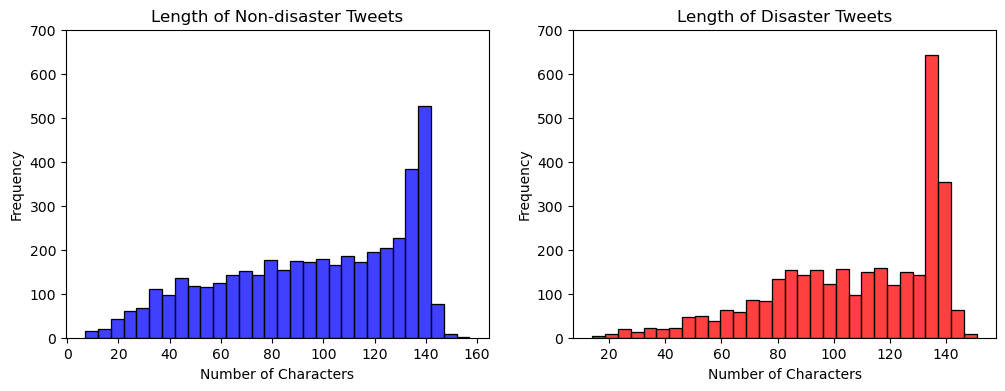

In [6]:

# 2-3. Text Length Distribution
# We will analyze the distribution of text lengths for both 'Non-disaster' and 'Disaster' tweets.

train_data["length"] = train_data["text"].apply(len)

# Filter the data for target = 0 and target = 1
target_0_data = train_data[train_data["target"] == 0]
target_1_data = train_data[train_data["target"] == 1]

# Create subplots for side-by-side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the histogram for target = 0
sns.histplot(target_0_data["length"], color='blue', bins=30, ax=ax1)
ax1.set_title("Length of Non-disaster Tweets")
ax1.set_xlabel("Number of Characters")
ax1.set_ylabel("Frequency")
ax1.set_ylim(0, 700)

# Plot the histogram for target = 1
sns.histplot(target_1_data["length"], color='red', bins=30, ax=ax2)
ax2.set_title("Length of Disaster Tweets")
ax2.set_xlabel("Number of Characters")
ax2.set_ylabel("Frequency")
ax2.set_ylim(0, 700)

plt.show()


In [7]:

# 2-4. Text Preprocessing
# We will clean the text data by removing punctuation, URLs, HTML tags, non-ASCII characters, and stopwords.
# We will also replace abbreviations with their full forms.

# Function to clean text
def clean_text(text):
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Remove URLs
    text = re.sub(r'https?://\\S+|www\\.\\S+', 'URL', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove non-ASCII characters
    text = ''.join([char for char in text if char in string.printable])
    
    return text

# Apply text cleaning
train_data['clean_text'] = train_data['text'].apply(clean_text)
print(train_data.head())

# We will now remove stopwords using the NLTK library.

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

train_data['clean_text'] = train_data['clean_text'].apply(remove_stopwords)
print(train_data.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  length                                         clean_text  
0       1      69  Our Deeds are the Reason of this earthquake Ma...  
1       1      38              Forest fire near La Ronge Sask Canada  
2       1     133  All residents asked to shelter in place are be...  
3       1      65  13000 people receive wildfires evacuation orde...  
4       1      88  Just got sent this photo from Ruby Alaska as s...  
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\farza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:

# 3. Model Architecture
# 3-1. Splitting the Train and Validation Data
# We will split the training data into 80% training and 20% validation sets.

y = train_data['target']
X_train, X_valid, y_train, y_valid = train_test_split(train_data['clean_text'], y, test_size=0.2, random_state=42)

# 3-2. Tokenization and Padding
# We will tokenize the text data and pad the sequences to ensure uniform input length.

max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)

X_train = pad_sequences(X_train)
X_valid = pad_sequences(X_valid)

# 3-3. Building and Training the LSTM Model
# We will build an LSTM model and train it using the training data.

embed_dim = 32
lstm_out = 32

def build_model(embed_dim, lstm_out):
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = build_model(embed_dim, lstm_out)
model.summary()

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6052 - loss: 0.6632 - val_accuracy: 0.7899 - val_loss: 0.4786
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8162 - loss: 0.4207 - val_accuracy: 0.7866 - val_loss: 0.4523
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8557 - loss: 0.3528 - val_accuracy: 0.7925 - val_loss: 0.4643
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8825 - loss: 0.2963 - val_accuracy: 0.7833 - val_loss: 0.4934
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8880 - loss: 0.2725 - val_accuracy: 0.7781 - val_loss: 0.5262
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9069 - loss: 0.2457 - val_accuracy: 0.7768 - val_loss: 0.5514
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9083 - loss: 0.2235 - val_accuracy: 0.7689 - val_loss: 0.5897
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9203 - loss: 0.2127 - val_accu

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Accuracy: 0.7518056467498359
Recall: 0.6918335901386748
Precision: 0.7161084529505582


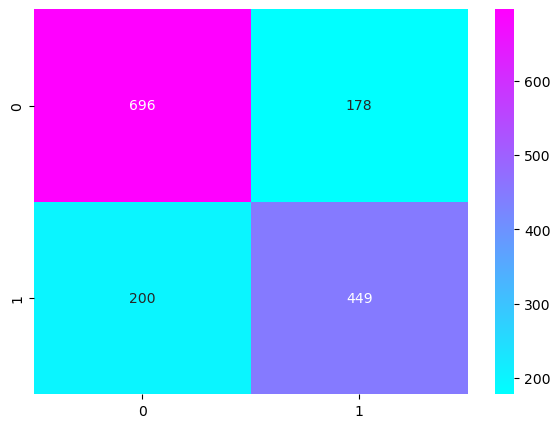

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       874
           1       0.72      0.69      0.70       649

    accuracy                           0.75      1523
   macro avg       0.75      0.74      0.75      1523
weighted avg       0.75      0.75      0.75      1523



In [9]:

# 4. Results and Analysis
# 4-1. Evaluation
# We will evaluate the model using accuracy, recall, and precision.

y_pred = model.predict(X_valid).round()

print('Accuracy:', accuracy_score(y_valid, y_pred))
print('Recall:', recall_score(y_valid, y_pred))
print('Precision:', precision_score(y_valid, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cool')
plt.show()

# Classification Report
print(classification_report(y_valid, y_pred))


# 5. Conclusion
In this project, we built an LSTM model to predict whether a tweet is related to a disaster or not.
#The model achieved reasonable accuracy, recall, and precision, indicating its effectiveness in this task.

Future improvements can be made by experimenting with different model architectures, hyperparameters, and more advanced text preprocessing techniques.

# References
Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets.
https://www.kaggle.com/c/nlp-getting-started
